<a href="https://colab.research.google.com/github/marreapato/Multi-Agent-Course/blob/main/virus_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install agentpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00


In [3]:
# Model design
import agentpy as ap
import networkx as nx
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import numpy as no

In [4]:
class Person(ap.Agent):

    def setup(self):
        """ Initialize a new variable at agent creation. """
        self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2

    def being_sick(self):
        """ Spread disease to peers in the network. """
        rng = self.model.random
        for n in self.network.neighbors(self):
            if n.condition == 0 and self.p.infection_chance > rng.random():
                n.condition = 1  # Infect susceptible peer
        if self.p.recovery_chance > rng.random():
            self.condition = 2  # Recover from infection

In [5]:
class VirusModel(ap.Model):

    def setup(self):
        """ Initialize the agents and network of the model. """

        # Prepare a small-world network
        graph = nx.watts_strogatz_graph(
            self.p.population,
            self.p.number_of_neighbors,
            self.p.network_randomness)

        # Create agents and network
        self.agents = ap.AgentList(self, self.p.population, Person)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)

        # Infect a random share of the population
        I0 = int(self.p.initial_infection_share * self.p.population)
        self.agents.random(I0).condition = 1

    def update(self):
        """ Record variables after setup and each step. """

        # Record share of agents with each condition
        for i, c in enumerate(('S', 'I', 'R')):
            n_agents = len(self.agents.select(self.agents.condition == i))
            self[c] = n_agents / self.p.population
            self.record(c)

        # Stop simulation if disease is gone
        if self.I == 0:
            self.stop()

    def step(self):
        """ Define the models' events per simulation step. """

        # Call 'being_sick' for infected agents
        self.agents.select(self.agents.condition == 1).being_sick()

    def end(self):
        """ Record evaluation measures at the end of the simulation. """

        # Record final evaluation measures
        self.report('Total share infected', self.I + self.R)
        self.report('Peak share infected', max(self.log['I']))

In [6]:
parameters = {
    'population': 1000,
    'infection_chance': 0.3,
    'recovery_chance': 0.1,
    'initial_infection_share': 0.1,
    'number_of_neighbors': 2,
    'network_randomness': 0.5
}

model = VirusModel(parameters)
results = model.run()

Completed: 80 steps
Run time: 0:00:00.454375
Simulation finished


In [7]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 6 keys
'variables': 
    'VirusModel': DataFrame with 3 variables and 81 rows
'reporters': DataFrame with 3 variables and 1 row
}

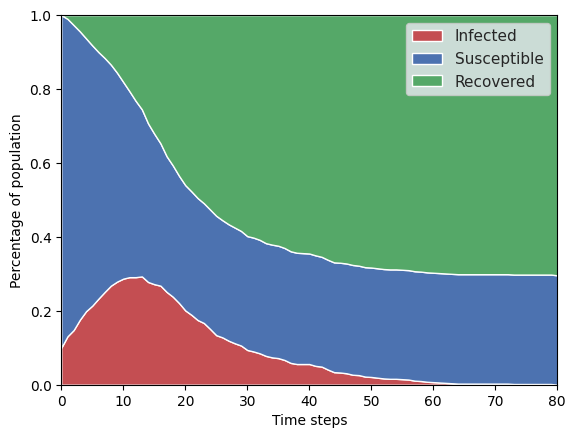

In [8]:
def virus_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R']]

    sns.set()
    ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered'],
                 colors = ['r', 'b', 'g'])

    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")

fig, ax = plt.subplots()
virus_stackplot(results.variables.VirusModel, ax)

In [9]:
def animation_plot(m, axs):
    ax1, ax2 = axs
    ax1.set_title("Virus spread")
    ax2.set_title(f"Share infected: {m.I}")

    # Plot stackplot on first axis
    virus_stackplot(m.output.variables.VirusModel, ax1)

    # Plot network on second axis
    color_dict = {0:'b', 1:'r', 2:'g'}
    colors = [color_dict[c] for c in m.agents.condition]
    nx.draw_circular(m.network.graph, node_color=colors,
                     node_size=50, ax=ax2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) # Prepare figure
parameters['population'] = 50 # Lower population for better visibility
animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

In [10]:
IPython.display.HTML(animation.to_jshtml())